# Housing Price Predictions

## Problem Statement

We'd like to create a proof-of-concept model that demonstrates we can achieve a low error metric despite incomplete or missing data. The only currently available dataset is the Ames Housing Price dataset, so we must use the resources at hand to construct an accurate model to show to non-technical stakeholders within the company.

## Executive Summary

Our dataset is composed of ~3000 observations of 80 variables, plus our target variable: the final sale price of the house. Our final evaluation for the model is based on a test set which has been stripped of final sale prices, so in order to evaluate our model we will need to conduct performance analysis against a holdout data set.

We will first reference the provided data dictionary to examine missing values in the data set and subjectively determine their most likely true value.

Next, we will tidy up variables which have small numbers of extreme observations (outliers) by binning the outliers with nearby values. We will also drop some features which we believe are too sparse (e.g. 2997 identical observations and 3 distinct ones) for models to interpret sensibly.

Third, we will conduct feature engineering to create combinations of our different variables based on subject-matter knowledge (For example, total interior square footage of the house may be more meaningful than the square footage of the basement and the square footage of non-basement interior areas on their own), then isolate variables which have high independent predictive power and emphasize them to our models by adding them raised to the 2nd, 3rd, and 1/2 powers.

Finally, we will select appropriate models to test plus a null model, and compare them individually against a weighted ensemble model, which predicts the average of all the underlying model's predictions for each data point.

Our model evaluation metric has been chosen as Root Mean Squared Error. In context, the RMSE of our models reflects the idea that "Our model has an average error of $______ across all predictions." This is a concise and useful metric which is easily representable to stakeholders, or our fictional company's customers. 

The last step will be to submit our predictions on the original test data to an "Independent House Price Prediction Auditor," a.k.a. Kaggle, and find out the true performance of our model on unseen data.

## Table of Contents

1. [Problem Statement](#Problem-Statement)
- [Executive Summary](#Executive-Summary)
- [Loading Packages and Data](#Loading-Packages-and-Data)
- [Data Dictionary](#Data-Dictionary)
- [Data Cleaning](#Data-Cleaning)  
    - [Data Types and Data Dictionary Interpretation](#Data-Types-and-Data-Dictionary-Interpretation)
    - [NA Values](#NA-Values)
    - [Numeric-Variables](#Numeric-Variables)
    - [Categorical Variables](#Categorical-Variables)
    - [Low-occurrence column values identified in EDA](#Low-occurrence-column-values-identified-in-EDA)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Feature Engineering](#Feature-Engineering)
- [Model Preparation](#Model-Preparation)
- [Modeling](#Modeling)
- [Model Selection](#Model-Selection)
- [Model Evaluation](#Model-Evaluation)
- [Conclusion & Recommendations](#Conclusion-&-Recommendations)
- [References](#References)

## Loading Packages and Data

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV, ElasticNet, ElasticNetCV, SGDRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.diagnostic import kstest_normal
from scipy.stats import skew
from scipy.special import boxcox1p
from sklearn import metrics
import warnings


# Package Options
warnings.filterwarnings('ignore')
pd.set_option("max_rows", None)
pd.set_option('max_columns', None)

# Data
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

## Data Dictionary

[Plaintext Data Dictionary Here](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)

[Formatted Data Dictionary Here](https://www.kaggle.com/c/dsi-us-12-project-2-regression-challenge/data)

## Data Cleaning

### Data Types and Data Dictionary Interpretation

In order to clean and prepare this data correctly, we need to bring the training and testing data together, otherwise we may miss categorical values present in one set but not another, and have other difficulties with replicating our data cleaning on both sets.
to not loose track of which is which i will add a dummy column.

In [2]:
train['train'] = 1
test['train'] = 0

all_data = pd.concat([train, test])

In [3]:
all_data.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,train
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500.0,1
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000.0,1
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000.0,1
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000.0,1
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500.0,1


In [4]:
all_data.shape

(2929, 82)

In [5]:
train.shape

(2051, 82)

In [6]:
test.shape

(878, 81)

In [7]:
all_data.dtypes

Id                   int64
PID                  int64
MS SubClass          int64
MS Zoning           object
Lot Frontage       float64
Lot Area             int64
Street              object
Alley               object
Lot Shape           object
Land Contour        object
Utilities           object
Lot Config          object
Land Slope          object
Neighborhood        object
Condition 1         object
Condition 2         object
Bldg Type           object
House Style         object
Overall Qual         int64
Overall Cond         int64
Year Built           int64
Year Remod/Add       int64
Roof Style          object
Roof Matl           object
Exterior 1st        object
Exterior 2nd        object
Mas Vnr Type        object
Mas Vnr Area       float64
Exter Qual          object
Exter Cond          object
Foundation          object
Bsmt Qual           object
Bsmt Cond           object
Bsmt Exposure       object
BsmtFin Type 1      object
BsmtFin SF 1       float64
BsmtFin Type 2      object
B

After manually reviewing the datatypes of the columns, everything corresponds to the types indicated by the Data Dictionary. 

We note that there are many ordinal variables with the same scale (Po,Fa,TA,Gd,Ex) that we will convert to integer values.

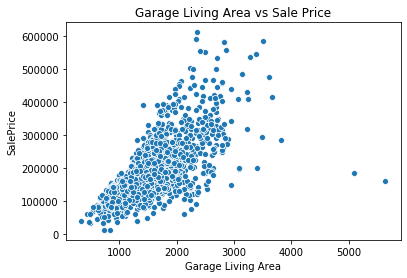

In [8]:
sns.scatterplot(train['Gr Liv Area'], train['SalePrice'])
plt.title('Garage Living Area vs Sale Price')
plt.xlabel('Garage Living Area')
plt.savefig("./assets/Garage Living Area vs Sale Price.png");

We can see that outliers were, indeed included in the dataset. However, only two of the ones indicated in the data dictionary appeared in our training set, so the other three may be in the test data.

In [9]:
test[test['Gr Liv Area'] > 4000]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,train
170,1761,528320050,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300,2396,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1,0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,0
463,1768,528351010,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,0


We need predictions for all entries in the test set, so outlier removal will not be an option in our data cleaning for the test data. However, we should remove the offending rows from the test data to avoid biasing the model.

In [10]:
train[train['Gr Liv Area'] > 4000]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,train
960,1499,908154235,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644.0,Unf,0.0,466.0,6110.0,GasA,Ex,Y,SBrkr,4692,950,0,5642,2.0,0.0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2.0,1418.0,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,160000,1
1885,2181,908154195,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,Stone,1224.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,4010.0,Unf,0.0,1085.0,5095.0,GasA,Ex,Y,SBrkr,5095,0,0,5095,1.0,1.0,2,1,2,1,Ex,15,Typ,2,Gd,Attchd,2008.0,Fin,3.0,1154.0,TA,TA,Y,546,484,0,0,0,0,NaN,NaN,Elev,17000,10,2007,New,183850,1


In [11]:
all_data.drop([960, 1885], inplace=True)

all_data.reset_index(drop=True, inplace=True)

### NA Values

Reviewing our Data Dictionary, we see that an "NA" in "Pool QC" means "No Pool."   
An "NA" in "Misc Feature" means "No miscellaneous feature."  
An "NA" in "Alley" means "No alley access."  
An "NA" in "Fence" means "No Fence"  
An "NA" in "FireplaceQu" means "No Fireplace"  
"NA" in Garage Finish, Condition, Quality, Yr Built, and Type means "No Garage"  
"NA" in the Basement columns means "No Basement"  
"NA" in Masonry Veneer means no masonry  

We'd like to look closer at missing entries in "Garage Cars" and "Garage Area"

Missing entries in Basement Square Footage most likely represent no basement.

An "NA" in "Lot Frontage" seems to mean that the property is not connected to streets.

"NA" in Electrical should be assigned the minimum value of the ordinal system

Missing values in "Sale Price" are simply the testing data, which have the column removed.

In [12]:
all_data.isna().sum().sort_values(ascending=False)[:29]

Pool QC           2915
Misc Feature      2822
Alley             2729
Fence             2355
Fireplace Qu      1422
SalePrice          878
Lot Frontage       490
Garage Yr Blt      159
Garage Qual        159
Garage Finish      159
Garage Cond        159
Garage Type        157
Bsmt Exposure       83
BsmtFin Type 2      81
BsmtFin Type 1      80
Bsmt Cond           80
Bsmt Qual           80
Mas Vnr Area        23
Mas Vnr Type        23
Bsmt Half Bath       2
Bsmt Full Bath       2
Garage Area          1
Garage Cars          1
Bsmt Unf SF          1
BsmtFin SF 2         1
BsmtFin SF 1         1
Total Bsmt SF        1
Electrical           1
Year Built           0
dtype: int64

### Handling missing Values in string columns where "NA" means "No"

In [13]:
string_nas = ['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Fireplace Qu',
              'Garage Finish', 'Garage Cond', 'Garage Type', 'Garage Qual',
              'BsmtFin Type 1', 'BsmtFin Type 2', 'Bsmt Exposure',
              'Bsmt Cond', 'Bsmt Qual', 'Mas Vnr Type']

all_data[string_nas] = all_data[string_nas].fillna('No')

### Handling missing values in numeric columns:

In [14]:
numeric_NAs = ['Lot Frontage', 'Mas Vnr Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Total Bsmt SF',
               'Bsmt Unf SF', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Garage Cars', 'Garage Area', 'Garage Yr Blt']
all_data[numeric_NAs] = all_data[numeric_NAs].fillna(0)

### Assigning NAs in Electrical to minimum value of ordinal

In [15]:
all_data['Electrical'] = all_data['Electrical'].fillna('Mix')

Verify that all NAs have been filled

In [16]:
all_data.isna().sum().sort_values(ascending=False)[:28]

SalePrice         878
Exter Cond          0
Year Remod/Add      0
Roof Style          0
Roof Matl           0
Exterior 1st        0
Exterior 2nd        0
Mas Vnr Type        0
Mas Vnr Area        0
Exter Qual          0
train               0
Year Built          0
Bsmt Qual           0
Bsmt Cond           0
Bsmt Exposure       0
BsmtFin Type 1      0
BsmtFin SF 1        0
BsmtFin Type 2      0
BsmtFin SF 2        0
Bsmt Unf SF         0
Foundation          0
Overall Cond        0
Overall Qual        0
Lot Shape           0
PID                 0
MS SubClass         0
MS Zoning           0
Lot Frontage        0
dtype: int64

### Numeric Variables

In [17]:
all_data.describe().transpose()[['mean', 'std', 'min', 'max']]

,mean,std,min,max
Id,1.464999e+03,8.461886e+02,1.0,2.930000e+03
PID,7.142660e+08,1.887256e+08,526301100.0,1.007100e+09
MS SubClass,5.739836e+01,4.265422e+01,20.0,1.900000e+02
Lot Frontage,5.751179e+01,3.312974e+01,0.0,3.130000e+02
Lot Area,1.010937e+04,7.782876e+03,1300.0,2.152450e+05
Overall Qual,6.090878e+00,1.406195e+00,1.0,1.000000e+01
Overall Cond,5.563717e+00,1.111960e+00,1.0,9.000000e+00
Year Built,1.971319e+03,3.023849e+01,1872.0,2.010000e+03
Year Remod/Add,1.984242e+03,2.085673e+01,1950.0,2.010000e+03
Mas Vnr Area,1.002501e+02,1.766269e+02,0.0,1.600000e+03


We note that Month Sold is given as 1-12, we should convert this to a categorical, as there is no numeric significance to the number of a month.  

We should likewise convert Year Sold into a categorical variable.

We note that there is an entry error in Garage Year Built, we should adjust this number or drop the row after investigating.

We note that MS SubClass is a numeric column which is actually meant to be interpreted as a categorical, we should convert the values to strings.

In [18]:
# Convert Year to categorical
all_data['Yr Sold'] = all_data['Yr Sold'].astype(str)

In [19]:
# Convert month to categorical
all_data['Mo Sold'] = all_data['Mo Sold'].map({
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep',
    10: 'Oct', 11: 'Nov', 12: 'Dec'})

In [20]:
# Investigate Garage Yr Blt entry error
all_data[all_data['Garage Yr Blt'] == 2207]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,train
1698,2261,916384070,20,RL,68.0,8298,Pave,No,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2006,2007,Hip,CompShg,VinylSd,VinylSd,No,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,583.0,Unf,0.0,963.0,1546.0,GasA,Ex,Y,SBrkr,1564,0,0,1564,0.0,0.0,2,0,2,1,Ex,6,Typ,1,Gd,Attchd,2207.0,RFn,2.0,502.0,TA,TA,Y,132,0,0,0,0,0,No,No,No,0,Sep,2007,New,267300.0,1


We see that the home was built in 2006, and remodeled in 2007. We can safely conclude that 2207 should be 2007.

In [21]:
# Fix erroneous entry in Garage Yr Blt
all_data[all_data['Garage Yr Blt'] == 2207]['Garage Yr Blt'] = 2007

In [22]:
# Convert MS SubClass to string
all_data['MS SubClass'] = all_data['MS SubClass'].astype(str)

### Categorical Variables

As we noted after reviewing the Data Dictionary, a number of ordinal variables share a consistent scale. Let's adjust these to an integer scale.

We will raise all ordinals to the second power to increase the model's sense of scale between a very bad and very good quality.

In [23]:
# Standard Ordinal Variables
ordinal_shared = ['Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Heating QC', 'Kitchen Qual',
                  'Fireplace Qu', 'Garage Qual', 'Garage Cond', 'Pool QC']

ord_map = {'No': 0, 'Po': 1, 'Fa': 2**2, 'TA': 3**2, 'Gd': 4**2, 'Ex': 5**2}

for col in ordinal_shared:
    all_data[col] = all_data[col].map(ord_map)

In [24]:
# Non-Standard Ordinal Variables
all_data['Bsmt Exposure'] = all_data['Bsmt Exposure'].map({
    'No': 0, 'Mn': 1, 'Av': 2**2, 'Gd': 3**2})
all_data['Lot Shape'] = all_data['Lot Shape'].map({
    'No': 0, 'IR3': 1, 'IR2': 2**2, 'IR1': 3**2, 'Reg': 4**2})
all_data['Utilities'] = all_data['Utilities'].map({
    'ELO': 0, 'NoSeWa': 1, 'NoSewr': 3**2, 'AllPub': 4**2})
all_data['Land Slope'] = all_data['Land Slope'].map({
    'Sev': 0, 'Mod': 1, 'Gtl': 2**2})
all_data['BsmtFin Type 1'] = all_data['BsmtFin Type 1'].map({
    'No': 0, 'Unf': 1, 'LwQ': 2**2, 'Rec': 3**2, 'BLQ': 4**2, 'ALQ': 5**2, 'GLQ': 6**2})
all_data['BsmtFin Type 2'] = all_data['BsmtFin Type 2'].map({
    'No': 0, 'Unf': 1, 'LwQ': 2**2, 'Rec': 3**2, 'BLQ': 4**2, 'ALQ': 5**2, 'GLQ': 6**2})
all_data['Electrical'] = all_data['Electrical'].map({
    'Mix': 0, 'FuseP': 1, 'FuseF': 2**2, 'FuseA': 3**2, 'SBrkr': 4**2})
all_data['Functional'] = all_data['Functional'].map({
    'Sal': 0, 'Sev': 1, 'Maj2': 2**2, 'Maj1': 3**2, 'Mod': 4**2, 'Min2': 5**2, 'Min1': 6**2, 'Typ': 7**2})
all_data['Garage Finish'] = all_data['Garage Finish'].map({
    'No': 0, 'Unf': 1, 'RFn': 2**2, 'Fin': 3**2})
all_data['Paved Drive'] = all_data['Paved Drive'].map({
    'N': 0, 'P': 1, 'Y': 2**2})
all_data['Fence'] = all_data['Fence'].map({
    'No': 0, 'MnWw': 1, 'GdWo': 2**2, 'MnPrv': 3**2, 'GdPrv': 4**2})

### Low-occurrence column values identified in EDA

We'd like to look at some columns which we identified during EDA, and have few-to-no variation in values:

In [25]:
all_data['Lot Shape'].value_counts(normalize=True)

16    0.635121
9     0.333789
4     0.025965
1     0.005125
Name: Lot Shape, dtype: float64

"Lot Shape" value levels 1 and 2 are low-occurrence, so we will bin them with the 3rd tier

In [26]:
all_data['Lot Shape'] = all_data['Lot Shape'].map({
    1: 9, 4: 9, 9: 9, 16: 16})

In [27]:
all_data['Utilities'].value_counts(normalize=True)

16    0.998975
9     0.000683
1     0.000342
Name: Utilities, dtype: float64

In [28]:
all_data.drop(columns='Utilities', inplace=True)

"Utilities" only has 3 entries which vary from the most common value, we will drop the column.

In [29]:
all_data['Land Slope'].value_counts(normalize=True)

4    0.951828
1    0.042706
0    0.005466
Name: Land Slope, dtype: float64

Land Slope level 0 is uncommon, we will bin with level 1:

In [30]:
all_data['Land Slope'] = all_data['Land Slope'].map({
    0: 1, 1: 1, 4: 4})

In [31]:
all_data['Exter Cond'].value_counts(normalize=True)

9     0.869833
16    0.102152
4     0.022890
25    0.004100
1     0.001025
Name: Exter Cond, dtype: float64

"Exter Cond" only has a handful of level 1, 2, and 5 values, so we'll bin those values:

In [32]:
all_data['Exter Cond'] = all_data['Exter Cond'].map({
    1: 9, 4: 9, 9: 9, 16: 16, 25: 16})

In [33]:
all_data['Exter Qual'].value_counts(normalize=True)

9     0.614622
16    0.337889
25    0.035531
4     0.011958
Name: Exter Qual, dtype: float64

"Exter Qual" levels 2 and 5 are low-occurrence, we will bin them:

In [34]:
all_data['Exter Qual'] = all_data['Exter Qual'].map({
    4: 9, 9: 9, 16: 16, 25: 16})

In [35]:
all_data['Bsmt Qual'].value_counts(normalize=True)

9     0.438333
16    0.416467
25    0.087120
4     0.030065
0     0.027332
1     0.000683
Name: Bsmt Qual, dtype: float64

"Bsmt Qual" levels 0, 1, and 2 are low-occurrence, we will bin them:

In [36]:
all_data['Bsmt Qual'] = all_data['Bsmt Qual'].map({
    0: 9, 1: 9, 4: 9, 9: 9, 16: 16, 25: 25})

In [37]:
all_data['Bsmt Cond'].value_counts(normalize=True)

9     0.892723
16    0.041681
4     0.035531
0     0.027332
1     0.001708
25    0.001025
Name: Bsmt Cond, dtype: float64

"Bsmt Cond" levels 0, 1, and 5 are low-occurrence, we will bin them:

In [38]:
all_data['Bsmt Cond'] = all_data['Bsmt Cond'].map({
    0: 4, 1: 4, 4: 4, 9: 9, 16: 16, 25: 16})

In [39]:
all_data['BsmtFin Type 2'].value_counts(normalize=True)

1     0.852750
9     0.036215
4     0.030407
0     0.027673
16    0.023232
25    0.018107
36    0.011616
Name: BsmtFin Type 2, dtype: float64

"BsmtFin Type 2" levels 5 and 6 are low-occurence, we will bin them:

In [40]:
all_data['BsmtFin Type 2'] = all_data['BsmtFin Type 2'].map({
    0: 0, 1: 1, 4: 4, 9: 9, 16: 16, 25: 16, 36: 16})

In [41]:
all_data['Heating QC'].value_counts(normalize=True)

25    0.509737
9     0.295183
16    0.162624
4     0.031431
1     0.001025
Name: Heating QC, dtype: float64

"Heating QC" level 1 is low-occurrence, we will bin it:

In [42]:
all_data['Heating QC'] = all_data['Heating QC'].map({
    1: 4, 4: 4, 9: 9, 16: 16, 25: 25})

In [43]:
all_data['Electrical'].value_counts(normalize=True)

16    0.915272
9     0.064230
4     0.017082
1     0.002733
0     0.000683
Name: Electrical, dtype: float64

"Electrical" levels 0 and 1 are low-occurrence, we will bin them:

In [44]:
all_data['Electrical'] = all_data['Electrical'].map({
    0: 4, 1: 4, 4: 4, 9: 9, 16: 16})

In [45]:
all_data['Bsmt Full Bath'].value_counts(normalize=True)

0.0    0.583874
1.0    0.402802
2.0    0.012641
3.0    0.000683
Name: Bsmt Full Bath, dtype: float64

3 Full Basement Bathrooms is rare, we will bin those

In [46]:
all_data['Bsmt Full Bath'] = all_data['Bsmt Full Bath'].map({
    0: 0, 1: 1, 2: 2, 3: 2})

In [47]:
all_data['Bsmt Half Bath'].value_counts(normalize=True)

0.0    0.940553
1.0    0.058080
2.0    0.001367
Name: Bsmt Half Bath, dtype: float64

2 half basement bathrooms is rare, we will bin

In [48]:
all_data['Bsmt Half Bath'] = all_data['Bsmt Half Bath'].map({
    0: 0, 1: 1, 2: 1})

In [49]:
all_data['Full Bath'].value_counts(normalize=True)

2    0.522720
1    0.450290
3    0.021524
0    0.004100
4    0.001367
Name: Full Bath, dtype: float64

4 and 0 Full Baths is uncommon, we will bin

In [50]:
all_data['Full Bath'] = all_data['Full Bath'].map({
    0: 1, 1: 1, 2: 2, 3: 3, 4: 3})

In [51]:
all_data['Half Bath'].value_counts(normalize=True)

0    0.629655
1    0.361804
2    0.008541
Name: Half Bath, dtype: float64

2 Half Baths is uncommon, we will bin them

In [52]:
all_data['Half Bath'] = all_data['Half Bath'].map({
    0: 0, 1: 1, 2: 1})

In [53]:
all_data['Bedroom AbvGr'].value_counts(normalize=True)

3    0.544927
2    0.253502
4    0.136659
1    0.038264
5    0.016399
6    0.007175
0    0.002733
8    0.000342
Name: Bedroom AbvGr, dtype: float64

0, 6, and 8 bedrooms above grade are uncommon, we will bin

In [54]:
all_data['Bedroom AbvGr'] = all_data['Bedroom AbvGr'].map({
    0: 1, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 5, 8: 5})

In [55]:
all_data['Kitchen AbvGr'].value_counts(normalize=True)

1    0.954219
2    0.044072
0    0.001025
3    0.000683
Name: Kitchen AbvGr, dtype: float64

0 and 3 kitchens are rare, we will bin

In [56]:
all_data['Kitchen AbvGr'] = all_data['Kitchen AbvGr'].map({
    0: 1, 1: 1, 2: 2, 3: 2})

In [57]:
all_data['Kitchen Qual'].value_counts(normalize=True)

9     0.510420
16    0.396310
25    0.069013
4     0.023915
1     0.000342
Name: Kitchen Qual, dtype: float64

Kitchen Quality = 1 is uncommon, we will bin

In [58]:
all_data['Kitchen Qual'] = all_data['Kitchen Qual'].map({
    1: 4, 4: 4, 9: 9, 16: 16, 25: 25})

In [59]:
all_data['TotRms AbvGrd'].value_counts(normalize=True)

6     0.288350
7     0.221729
5     0.200205
8     0.118551
4     0.069354
9     0.048855
10    0.027332
11    0.010591
3     0.008883
12    0.005125
13    0.000342
14    0.000342
2     0.000342
Name: TotRms AbvGrd, dtype: float64

We have outliers at 2,3,and 11-15 rooms above grade, we will bin these

In [60]:
all_data['TotRms AbvGrd'] = all_data['TotRms AbvGrd'].map({
    2: 4, 3: 4, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10})

In [61]:
all_data['Functional'].value_counts(normalize=True)

49    0.930987
25    0.023915
36    0.022207
16    0.011958
9     0.006491
4     0.003075
1     0.000683
0     0.000683
Name: Functional, dtype: float64

"Functional" levels 0-4 are underrepresented, we will bin

In [62]:
all_data['Functional'] = all_data['Functional'].map({
    0: 16, 1: 16, 4: 16, 9: 16, 16: 16, 25: 25, 36: 36, 49: 49})

In [63]:
all_data['Fireplaces'].value_counts(normalize=True)

0    0.485822
1    0.434916
2    0.075162
3    0.003758
4    0.000342
Name: Fireplaces, dtype: float64

3 and 4 fireplaces are uncommon, we wil bin

In [64]:
all_data['Fireplaces'] = all_data['Fireplaces'].map({
    0: 0, 1: 1, 2: 2, 3: 2, 4: 2})

In [65]:
all_data['Garage Cars'].value_counts(normalize=True)

2.0    0.547318
1.0    0.265801
3.0    0.127093
0.0    0.053980
4.0    0.005466
5.0    0.000342
Name: Garage Cars, dtype: float64

4 and 5-car garages are uncommon, we will bin

In [66]:
all_data['Garage Cars'] = all_data['Garage Cars'].map({
    0: 0, 1: 1, 2: 2, 3: 3, 4: 3, 5: 3})

In [67]:
all_data['Garage Qual'].value_counts(normalize=True)

9     0.892381
0     0.054322
4     0.042364
16    0.008200
1     0.001708
25    0.001025
Name: Garage Qual, dtype: float64

Garage quality levels of 1 or above level 3 are uncommon, we will bin

In [68]:
all_data['Garage Qual'] = all_data['Garage Qual'].map({
    0: 0, 1: 0, 4: 4, 9: 9, 16: 9, 25: 9})

In [69]:
all_data['Garage Cond'].value_counts(normalize=True)

9     0.909464
0     0.054322
4     0.025282
16    0.005125
1     0.004783
25    0.001025
Name: Garage Cond, dtype: float64

Garage Condition levels of 1, 4 and 5 are uncommon, we will bin

In [70]:
all_data['Garage Cond'] = all_data['Garage Cond'].map({
    0: 0, 1: 0, 4: 4, 9: 9, 16: 9, 25: 9})

In [71]:
all_data['Pool QC'].value_counts(normalize = True)

0     0.995900
25    0.001367
9     0.001025
16    0.001025
4     0.000683
Name: Pool QC, dtype: float64

Pool Quality levels are too sparse, we will bin them:

In [72]:
all_data['Pool QC'] = all_data['Pool QC'].map({
    0:0, 4:25, 9:25, 16:25, 25:25})

In [73]:
np.sum(all_data['Pool QC'] > 0)

12

In [74]:
all_data['Fence'].value_counts(normalize=True)

0     0.804578
9     0.112743
16    0.040314
4     0.038264
1     0.004100
Name: Fence, dtype: float64

Fence levels of 1 are uncommon, we will bin

In [75]:
all_data['Fence'] = all_data['Fence'].map({
    0: 0, 1: 4, 4: 4, 9: 9, 16: 16})

In [76]:
np.sum(all_data['Misc Val'] > 0)

102

There are only 103 entries where "Misc Val" is greater than 0, we should also take a look at "Misc Feature", but will probably drop these columns.

In [77]:
all_data['Misc Feature'].value_counts(normalize=True)

No      0.964127
Shed    0.032456
Gar2    0.001708
Othr    0.001367
TenC    0.000342
Name: Misc Feature, dtype: float64

In [78]:
all_data.drop(columns=['Misc Val', 'Misc Feature'], inplace=True)

In [79]:
# Check to make sure our mappings didn't introduce NAs, excluded from final submission
all_data.isna().sum().sort_values(ascending=False)[:28]

SalePrice         878
Total Bsmt SF       0
Roof Style          0
Roof Matl           0
Exterior 1st        0
Exterior 2nd        0
Mas Vnr Type        0
Mas Vnr Area        0
Exter Qual          0
Exter Cond          0
Foundation          0
Bsmt Qual           0
Bsmt Cond           0
Bsmt Exposure       0
BsmtFin Type 1      0
BsmtFin SF 1        0
BsmtFin Type 2      0
BsmtFin SF 2        0
Bsmt Unf SF         0
Year Remod/Add      0
train               0
Overall Cond        0
Lot Shape           0
PID                 0
MS SubClass         0
MS Zoning           0
Lot Frontage        0
Lot Area            0
dtype: int64

## Exploratory Data Analysis

In [80]:
corr = all_data.corr().unstack().sort_values()
corr = pd.DataFrame(corr['SalePrice'])
kot = corr[corr>=.5]
kot.dropna(inplace= True)
print(kot.shape)
kot

(17, 1)


,0
Mas Vnr Area,0.511273
TotRms AbvGrd,0.511997
Garage Finish,0.538295
Full Bath,0.546379
Fireplace Qu,0.548952
Year Remod/Add,0.550872
Year Built,0.572405
Exter Qual,0.634940
1st Flr SF,0.648252
Garage Area,0.655097


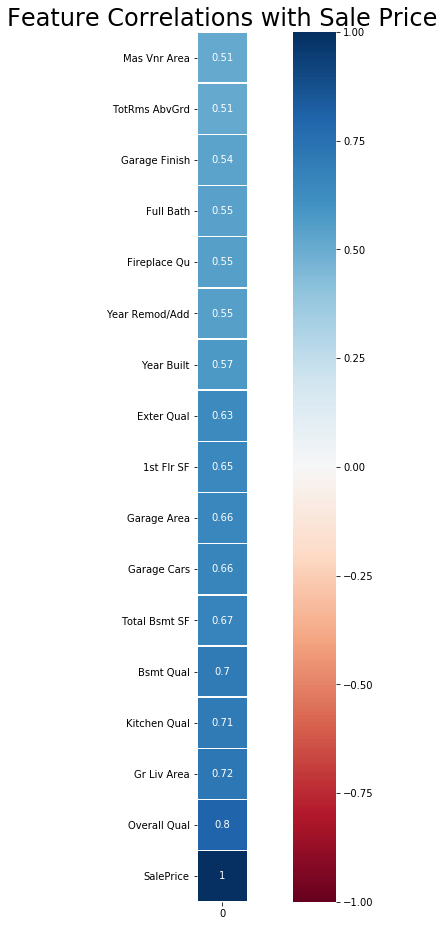

In [81]:
plt.figure(figsize=(16, 16))
sns.heatmap(kot, square = True, annot = True, vmin = -1, vmax = 1, linewidths = .5, cmap="RdBu")
plt.title('Feature Correlations with Sale Price', fontsize = 24)
plt.savefig("./assets/heatmap.png");

While we usually like to use heatmaps and pairplots, this dataset has too many variables, as seen above. So we'll need to examine things numerically and then in smaller subsets.

In [82]:
# Get variable correlations
corrs = all_data.corr()

# Show variables with the highest relationship to SalePrice
corrs.abs().sort_values('SalePrice', ascending=False)['SalePrice'][:30]

SalePrice         1.000000
Overall Qual      0.803462
Gr Liv Area       0.719463
Kitchen Qual      0.708139
Bsmt Qual         0.703986
Total Bsmt SF     0.665116
Garage Cars       0.659041
Garage Area       0.655097
1st Flr SF        0.648252
Exter Qual        0.634940
Year Built        0.572405
Year Remod/Add    0.550872
Fireplace Qu      0.548952
Full Bath         0.546379
Garage Finish     0.538295
TotRms AbvGrd     0.511997
Mas Vnr Area      0.511273
Fireplaces        0.477323
Heating QC        0.463339
BsmtFin SF 1      0.446103
Bsmt Exposure     0.425068
BsmtFin Type 1    0.392542
Open Porch SF     0.338545
Wood Deck SF      0.327629
Lot Shape         0.306707
Lot Area          0.303744
Half Bath         0.297091
Paved Drive       0.291830
Garage Qual       0.290110
Bsmt Full Bath    0.286634
Name: SalePrice, dtype: float64

Unsurprisingly, some of the generic "Quality" features are our best standalone predictors. 

Some of the "Area" features are also important.

Year Built/Remodeled are important.

Number of bathrooms, rooms, and fireplaces also seem important.

Let's take a look at distributions of our variables:

In [83]:
def hist_and_scatter(feature, title, featurename):
    figure, ax = plt.subplots(1, 2, figsize=(8, 6))
    ax[0].hist(feature)
    ax[1].scatter(feature, all_data['SalePrice'])
    ax[0].set_xlabel(featurename)
    ax[1].set_xlabel(featurename)
    ax[1].set_ylabel('SalePrice')
    figure.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.9])
    plt.savefig(f"./assets/Distribution and Relationship{title}.png")
    plt.show()

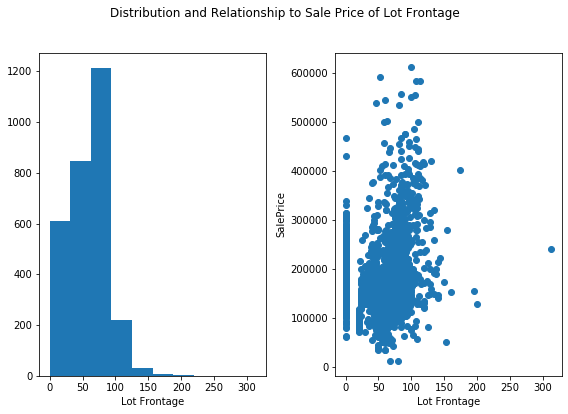

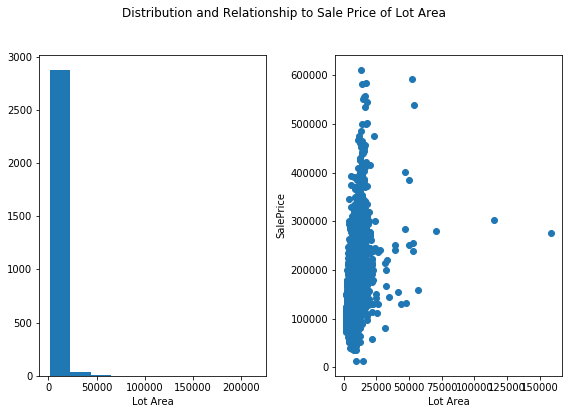

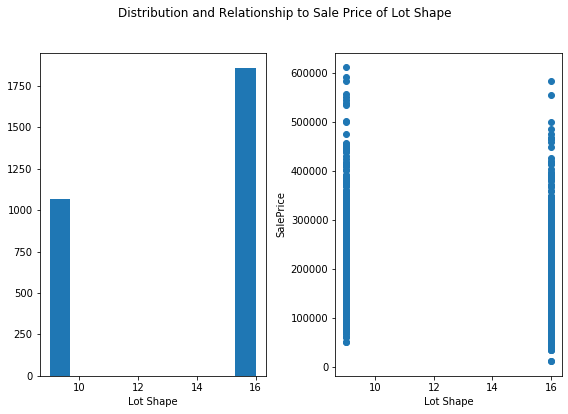

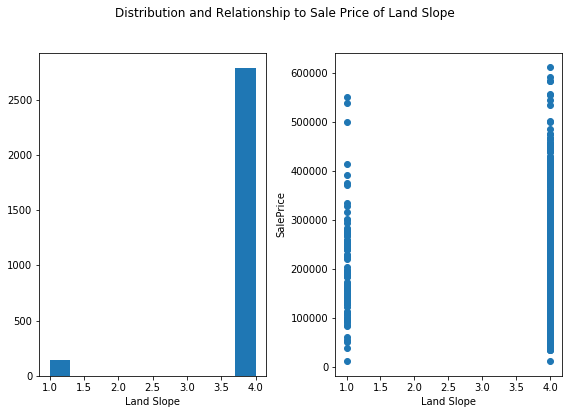

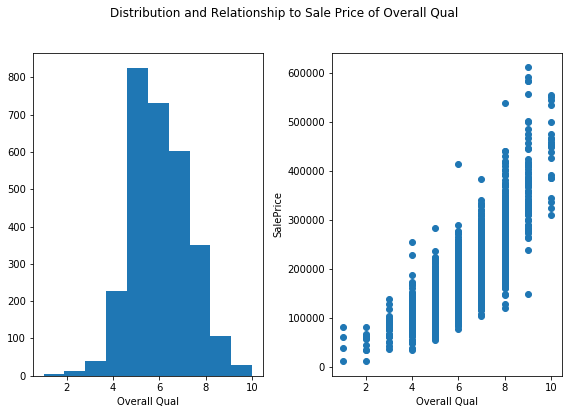

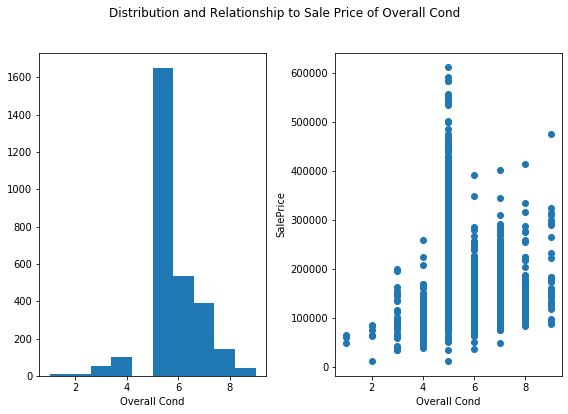

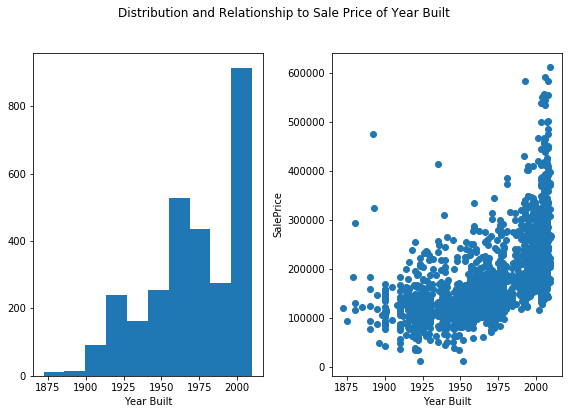

FileNotFoundError: [Errno 2] No such file or directory: './assets/Distribution and RelationshipDistribution and Relationship to Sale Price of Year Remod/Add.png'

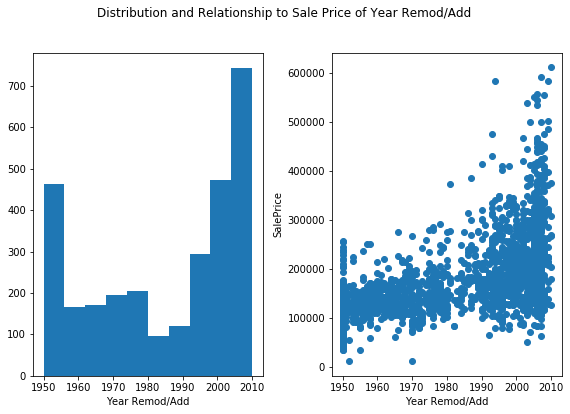

In [84]:
for col in all_data.columns[all_data.dtypes != 'object'][2:]:
    hist_and_scatter(
        all_data[col], f'Distribution and Relationship to Sale Price of {col}', col)

In our first runthrough, these visualizations allowed us to identify numerous "garbage" columns which we could throw out, or needed to be rebinned due to low frequency of observations

## Feature Engineering

[This Notebook](https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset) contained some really great engineered features that we'd like to include. 

First, we want to combine the internal square footage columns to get a total interior square footage

In [85]:
all_data['Total Int SF'] = all_data['Total Bsmt SF'] + all_data['Gr Liv Area']
all_data['All Flrs SF'] = all_data['1st Flr SF'] + all_data['2nd Flr SF']

There aren't very many houses with porches, particularly of certain types. We can combine all 4 porch columns into one to make this slightly more useful to our models.

In [86]:
all_data['Porch SF'] = all_data['Open Porch SF'] + \
    all_data['Enclosed Porch'] + \
    all_data['3Ssn Porch'] + all_data['Screen Porch']

We can combine Full and Half baths to get a total baths column

In [87]:
all_data['Baths'] = all_data['Full Bath'] + (.5 * all_data['Half Bath'])

Next, we're going to take [juliencs's](https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset) brilliant idea to create merged scores for all these values with Areas and Qualities, or Qualities and Conditions

In [88]:
all_data['Overall Grade'] = all_data['Overall Cond'] * all_data['Overall Qual']
all_data['Garage Grade'] = all_data['Garage Qual'] * all_data['Garage Cond']
all_data['Exter Grade'] = all_data['Exter Qual'] * all_data['Exter Cond']
all_data['Kitchen Score'] = all_data['Kitchen AbvGr'] * \
    all_data['Kitchen Qual']
all_data['Fireplace Score'] = all_data['Fireplaces'] * all_data['Fireplace Qu']
all_data['Garage Score'] = all_data['Garage Area'] * all_data['Garage Qual']

Finally, again based on [juliencs](https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset)'s approach, we're going to isolate the most impactful variables based on correlation to SalePrice and add  2nd and 3rd order polynomial versions of them:

In [89]:
highest_corr = all_data.corr().sort_values(
    ['SalePrice'], ascending=False)['SalePrice'][1:11]

highest_corr

Total Int SF     0.825818
Overall Qual     0.803462
All Flrs SF      0.728279
Gr Liv Area      0.719463
Kitchen Qual     0.708139
Bsmt Qual        0.703986
Garage Score     0.666028
Total Bsmt SF    0.665116
Garage Cars      0.659041
Garage Area      0.655097
Name: SalePrice, dtype: float64

In [90]:
for col in highest_corr.index:
    col2 = col + '-2'
    col3 = col + '-3'
    colsq = col + '-sq'
    all_data[col2] = all_data[col]**2
    all_data[col3] = all_data[col]**3
    all_data[colsq] = np.sqrt(all_data[col])

We'd like to find columns which have high skewness to transform. The goal here is to mitigate the impact of outliers. We'll use [juliencs's](https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset) method, but adapted based on [serigne](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard) and a few other Kaggle user's observations that the Box-Cox transformation has a better result than taking the natural log:

In [91]:
numerical_features = all_data.select_dtypes(exclude=["object"]).columns

In [92]:
skewness = all_data[numerical_features].apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
skewness = skewness
print(str(skewness.shape[0]) + " skewed numerical features to transform")
skewed_features = skewness.index

75 skewed numerical features to transform


In [93]:
skewed_features = list(skewed_features)

try:
    # Don't want to include our dummy "train" column if it got picked
    skewed_features.remove('train')
except:
    pass

In [94]:
# BoxCox of 1 + skewed features
lam = 0.15

for feature in skewed_features:
    all_data[feature] = boxcox1p(all_data[feature], lam)

We also want to be sure to log the sale price, which is highly non-normal

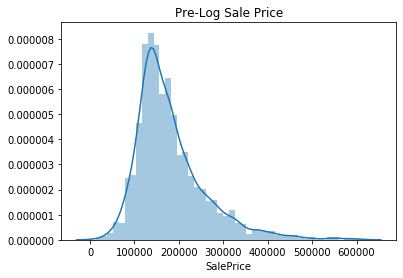

In [95]:
sns.distplot(all_data['SalePrice'])
plt.title('Pre-Log Sale Price')
plt.savefig("./assets/pre-log price.png");

In [96]:
all_data['SalePrice'] = np.log(all_data['SalePrice'])

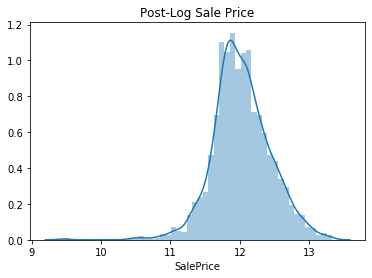

In [97]:
sns.distplot(all_data['SalePrice'])
plt.title('Post-Log Sale Price')
plt.savefig("./assets/post-log price.png");

## Model Preparation

We need to create dummy columns for all nominal and ordinal variables:

In [98]:
to_dummify = [col for col in all_data if all_data.dtypes[col] == 'object']

In [99]:
all_data = pd.get_dummies(data=all_data, columns=to_dummify, drop_first=True)

Next we establish our final sets for modeling, and conduct a train/test split for model evaluation:

In [100]:
# Prepare data for modeling
X = all_data.loc[all_data['train'] == 1, :]
null_preds = [np.exp(np.mean(all_data.loc[all_data['train'] == 1, 'SalePrice']))] 
X.drop(columns=['train', 'Id', 'PID', 'SalePrice'], inplace=True)
y = all_data.loc[all_data['train'] == 1, 'SalePrice']

In [101]:
# We still need a holdout out of our training data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
null_preds = null_preds * len(y_test)
train_null_preds = [null_preds[0]] * len(y_train)
train_true_values = np.exp(y_train)

In [102]:
# Set up scaled data for models requiring it
ss = StandardScaler()

ss.fit(X_train)

Z_train = ss.transform(X_train)
Z_test = ss.transform(X_test)

## Model Selection

Null Model Setup:

We were originally including an Ordinary Least Squares model, but the extent of our feature engineering damages it too much to be useful. Instead, we're running with Lasso, Ridge, ElasticNet, and Stochastic Gradient Descent regression models, along with the XGBoost gradient descent regressor.

In [103]:
%%capture
lasso = LassoCV()
lasso.fit(Z_train, y_train)
lasso_train_preds = np.exp(lasso.predict(Z_train))


In [104]:
%%capture
ridge = RidgeCV()
ridge.fit(Z_train, y_train)
ridge_train_preds = np.exp(ridge.predict(Z_train))


In [105]:
%%capture
elastic = ElasticNetCV()
elastic.fit(Z_train, y_train)
elastic_train_preds = np.exp(elastic.predict(Z_train))

We needed considerable hyperparameter tuning to get our Stochastic Gradient Descent hyperparameters right. We started with a set of hyperparameters adapted from [this blog post](http://dsdeepdive.blogspot.com/2015/08/hyperparameter-optimization-with-python.html) and honed in. Here is the final trial, preserved as comment. We chose parameters alpha = .523, n_iter_no_change = 27, and penalty = l2.

In [106]:
# sgd_params = {"n_iter_no_change": [23,24,25,26,27,28,29,30],
#               "alpha": [.52,.521,.522,.523,.524,.525,.526,.527,.528,.529,.53,.531,.532,.533,.534,.535,.536],
#               "penalty": ["l2"]}

# sgd = GridSearchCV(SGDRegressor(),
#                   sgd_params,
#                   cv = 5,
#                   verbose=1)
# sgd.fit(Z_train,y_train)


# sgd.best_params_
# {'alpha': 0.523, 'n_iter_no_change': 27, 'penalty': 'l2'}

In [107]:
sgd = SGDRegressor(alpha=0.523, n_iter_no_change=27,
                   penalty='l2', loss='huber')
sgd.fit(Z_train, y_train)
sgd_train_preds = np.exp(sgd.predict(Z_train))

To fit an Extreme Gradient Boosted Regressor, we followed [this handy guide](https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f) to tuning its hyperparameters. This is a Gradient Boosted decision tree regressor, and is fairly ubiquitous.

We CV the hyperparameters sequentially, and have commented out the code to do so.

In [108]:
# Set up XGB params

# XGB requires a custom matrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

xgb_params = {
    'max_depth': 5,
    'min_child_weight': 5.455594781168519,
    'eta': .05,
    'subsample': .5,
    'colsample_bytree': .9,
    'objective': 'reg:squarederror'
}

We need to cross-validate our best parameters for 'max_depth' and 'min_child_weight', again following the method of [this blog post](https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f), but adapting to solve for RMSE. We select max_depth = 5 and min_child_weight = 5.455594781168519. We will again comment this out, as it's just here to showcase methodology but doesn't need to run after selection has occurred.

In [109]:
# gridsearch_params = [
#     (max_depth, min_child_weight)
#     for max_depth in range(5,6)
#     for min_child_weight in list(np.logspace(0,1,20))
# ]

# min_rmse = float("Inf")
# best_params = None
# for max_depth, min_child_weight in gridsearch_params:
#     print("CV with max_depth={}, min_child_weight={}".format(
#                              max_depth,
#                              min_child_weight))
#     # Update our parameters
#     xgb_params['max_depth'] = max_depth
#     xgb_params['min_child_weight'] = min_child_weight
#     # Run CV
#     cv_results = xgb.cv(
#         xgb_params,
#         dtrain,
#         num_boost_round=291,
#         seed=42,
#         nfold=5,
#         metrics={'rmse'},
#         early_stopping_rounds=10
#     )
#     # Update best RMSE
#     mean_rmse = cv_results['test-rmse-mean'].min()
#     boost_rounds = cv_results['test-rmse-mean'].argmin()
#     print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
#     if mean_rmse < min_rmse:
#         min_rmse = mean_rmse
#         best_params = (max_depth,min_child_weight)
# print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

Next we will CV our subsample and colsample_bytree hyperparameters. We select subsample = .5, colsample_bytree = .9.

In [110]:
# gridsearch_params = [
#     (subsample, colsample)
#     for subsample in [i/10. for i in range(1,11,2)]
#     for colsample in [i/10. for i in range(1,11,2)]
# ]

# min_rmse = float("Inf")
# best_params = None
# # We start by the largest values and go down to the smallest
# for subsample, colsample in reversed(gridsearch_params):
#     print("CV with subsample={}, colsample={}".format(
#                              subsample,
#                              colsample))
#     # We update our parameters
#     xgb_params['subsample'] = subsample
#     xgb_params['colsample_bytree'] = colsample
#     # Run CV
#     cv_results = xgb.cv(
#         xgb_params,
#         dtrain,
#         num_boost_round=291,
#         seed=42,
#         nfold=5,
#         metrics={'rmse'},
#         early_stopping_rounds=10
#     )
#     # Update best score
#     mean_rmse = cv_results['test-rmse-mean'].min()
#     boost_rounds = cv_results['test-rmse-mean'].argmin()
#     print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
#     if mean_rmse < min_rmse:
#         min_rmse = mean_rmse
#         best_params = (subsample,colsample)
# print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

Last we will CV for our "eta" or "learning_rate". We select learning_rate = .05.

In [111]:
# min_rmse = float("Inf")
# best_params = None
# for eta in [.3, .2, .1, .05, .01, .005]:
#     print("CV with eta={}".format(eta))
#     # We update our parameters
#     xgb_params['eta'] = eta
#     # Run and time CV
#     cv_results = xgb.cv(
#             xgb_params,
#             dtrain,
#             num_boost_round=291,
#             seed=42,
#             nfold=5,
#             metrics=['rmse'],
#             early_stopping_rounds=10
#     )
#     # Update best score
#     mean_rmse = cv_results['test-rmse-mean'].min()
#     boost_rounds = cv_results['test-rmse-mean'].argmin()
#     print("\tRMSE {} for {} rounds\n".format(mean_rmse, boost_rounds))
#     if mean_rmse < min_rmse:
#         min_rmse = mean_rmse
#         best_params = eta
# print("Best params: {}, RMSE: {}".format(best_params, min_rmse))

To summarize, here are our final parameters:

In [112]:
xgb_params = {
    'max_depth': 5,
    'min_child_weight': 5.455594781168519,
    'eta': .05,
    'subsample': .5,
    'colsample_bytree': .9,
    'objective': 'reg:squarederror'
}

Now we can fit the XGB model:

In [113]:
%%capture
xgb_model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=999,
    evals=[(dtest, 'Test')]
)
xgb_train_preds = np.exp(xgb_model.predict(dtrain))


Now we will establish training-set predictions and R2 scores for all base models, plus the uniform-weight ensemble model we chose:

In [114]:
weighted_preds_train = .2 * lasso_train_preds + .2 * ridge_train_preds + .2 * \
    elastic_train_preds + .2 * sgd_train_preds + .2 * xgb_train_preds

lasso_r2_train = metrics.r2_score(train_true_values,lasso_train_preds)
ridge_r2_train = metrics.r2_score(train_true_values,ridge_train_preds)
elastic_r2_train = metrics.r2_score(train_true_values,elastic_train_preds)
sgd_r2_train = metrics.r2_score(train_true_values,sgd_train_preds)
xgb_r2_train = metrics.r2_score(train_true_values,xgb_train_preds)

Establishing a baseline R2 score against training data (to evaluate for overfitting only, not a judge of model performance—we only looked at RMSE on holdout data for evaluation)

In [115]:
for preds in [train_null_preds,lasso_train_preds,ridge_train_preds,elastic_train_preds,sgd_train_preds,
              xgb_train_preds,weighted_preds_train]:
    print('R2 Score:')
    print('\t' + str(metrics.r2_score(train_true_values,preds)))

R2 Score:
	-0.03452847414002291
R2 Score:
	0.9415661627775882
R2 Score:
	0.9523698027726974
R2 Score:
	0.94148944976168
R2 Score:
	0.9297670763303713
R2 Score:
	0.9986111595966436
R2 Score:
	0.9626655771489588


## Model Evaluation

Next we establish our models' individual and ensemble predictions on our holdout data:

In [116]:
# Establishing our predictions for each model on holdout data
true_values = np.exp(y_test)

lasso_preds = np.exp(lasso.predict(Z_test))
ridge_preds = np.exp(ridge.predict(Z_test))
elastic_preds = np.exp(elastic.predict(Z_test))
sgd_preds = np.exp(sgd.predict(Z_test))
xgb_preds = np.exp(xgb_model.predict(dtest))

# Constructing our ensemble prediction
weighted_preds = .2 * lasso_preds + .2 * ridge_preds + .2 * \
    elastic_preds + .2 * sgd_preds + .2 * xgb_preds

We calculate R2 scores for holdout data (again, used only to check for overfitting):

In [117]:
for preds in [null_preds,lasso_preds,ridge_preds,elastic_preds,sgd_preds,xgb_preds,weighted_preds]:
    print('R2 Score:')
    print('\t' + str(metrics.r2_score(true_values,preds)))

R2 Score:
	-0.03412296660380276
R2 Score:
	0.9423302751897922
R2 Score:
	0.9418239358683755
R2 Score:
	0.9422155490612368
R2 Score:
	0.9324074018303675
R2 Score:
	0.9484491626771459
R2 Score:
	0.9505622686759674


It may be interesting to see which features ElasticNet picked out as the most impactful. We can see that many of our polynomial columns are proving useful!

In [118]:
elastic_coefs = list(zip(X_train.columns, elastic.coef_))
elastic_coefs = pd.DataFrame(elastic_coefs, columns=['feature', 'coefficient'])
elastic_coefs['abs_coef'] = np.absolute(elastic_coefs['coefficient'])
elastic_coefs.sort_values('abs_coef', ascending=False)[0:20]

,feature,coefficient,abs_coef
67,Overall Qual-sq,0.051597,0.051597
6,Year Built,0.047083,0.047083
64,Total Int SF-sq,0.040790,0.040790
1,Lot Area,0.039239,0.039239
63,Total Int SF-3,0.029756,0.029756
56,Overall Grade,0.027692,0.027692
5,Overall Cond,0.022802,0.022802
15,BsmtFin SF 1,0.021599,0.021599
34,Functional,0.020085,0.020085
76,Kitchen Qual-sq,0.018517,0.018517


Our evaluation metric is RMSE, so let's look at each model's RMSE on holdout data individually, then the RMSE for the Ensemble methods:

In [119]:
# Null Model Performance
np.sqrt(metrics.mean_squared_error(true_values, null_preds))

80856.93455625905

In [120]:
# Lasso Performance
np.sqrt(metrics.mean_squared_error(true_values, lasso_preds))

19094.36060716242

In [121]:
# Ridge Performance
np.sqrt(metrics.mean_squared_error(true_values, ridge_preds))

19178.001517193727

In [122]:
# ElasticNet Performance
np.sqrt(metrics.mean_squared_error(true_values, elastic_preds))

19113.343996389314

In [123]:
# SGD Performance
np.sqrt(metrics.mean_squared_error(true_values, sgd_preds))

20671.916920224292

In [124]:
# XGB Performance
np.sqrt(metrics.mean_squared_error(true_values, xgb_preds))

18052.985883522837

In [125]:
# Ensemble 1 Performance
np.sqrt(metrics.mean_squared_error(true_values, weighted_preds))

17679.11199989818

We see that XGBoost has the best individual performance, and the ensemble model has a lower RMSE than any individual model. 

Next we want to look at the residual visualizations for each model, plus the ensembles:

In [126]:
def resid_plots(preds, title, true_values=true_values):
    resids = true_values - preds
    
    figure, ax = plt.subplots(1,3, figsize = (16,8))
    ax[0].hist(resids)
    ax[1].scatter(preds, resids)
    ax[2].scatter(preds,true_values)
    ax[0].set_xlabel('Residuals')
    ax[1].set_xlabel('Predicted Values')
    ax[1].set_ylabel('Residuals')
    ax[1].set_ylim(-125000,100000)
    ax[2].set_xlabel('Predicted Values')
    ax[2].set_ylabel('True Values')
    ax[2].set_xlim(0,600000)
    figure.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.9])
    plt.savefig(f"./assets/Distribution and Relationship{title}.png")
    plt.show()

In [127]:
preds_and_titles = [(lasso_preds,'Lasso Model Residual Plots'),
    (ridge_preds,'Ridge Model Residual Plots'),
    (elastic_preds,'ElasticNet Model Residual Plots'),
    (sgd_preds,'Stochastic Gradient Descent Residual Plots'),
    (xgb_preds,'XGBoost Residual Plots'),
    (weighted_preds, 'Ensemble Model Residual Plots'),
]

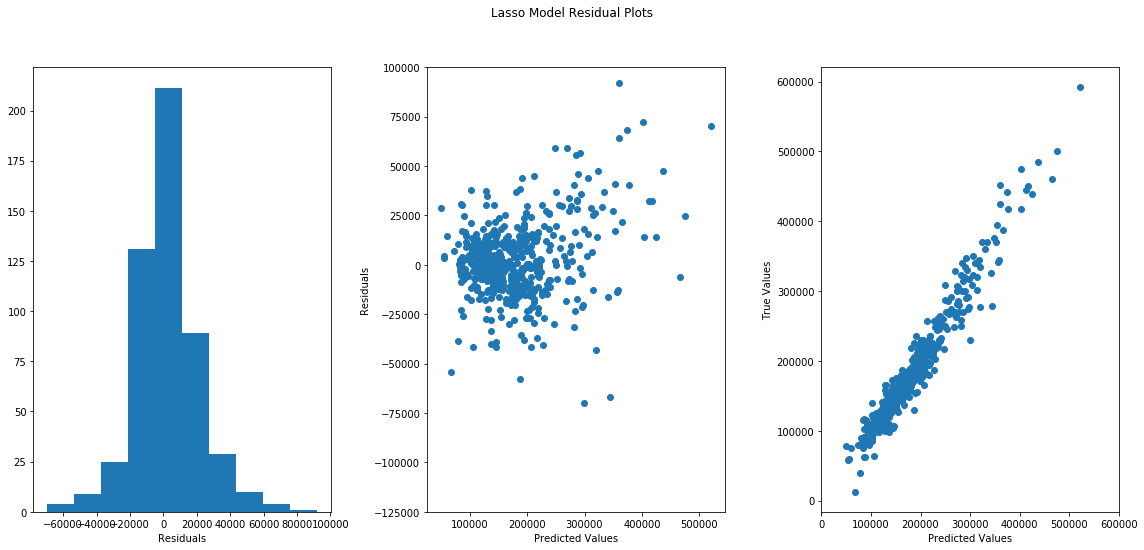

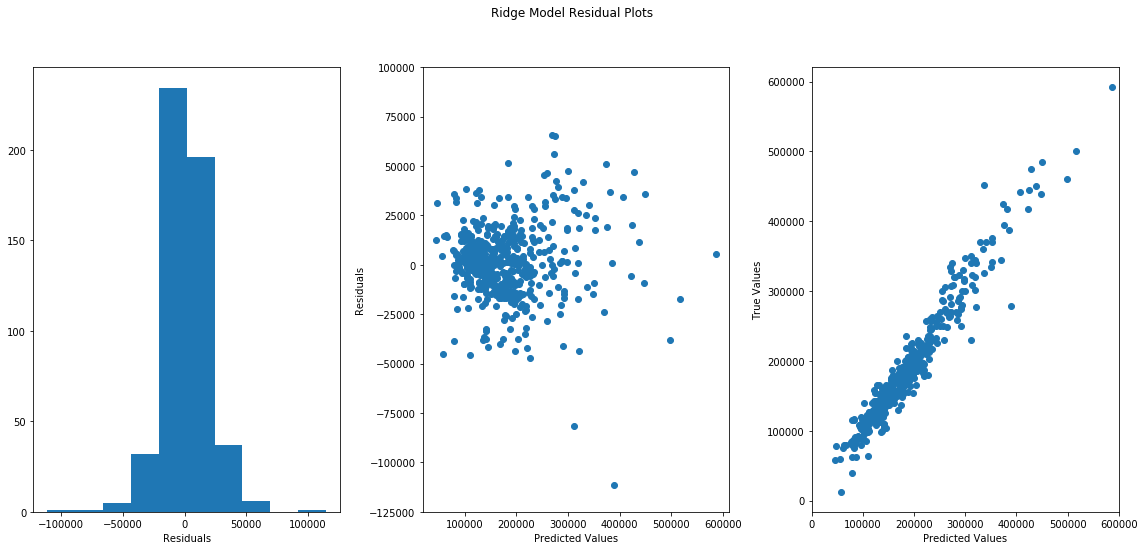

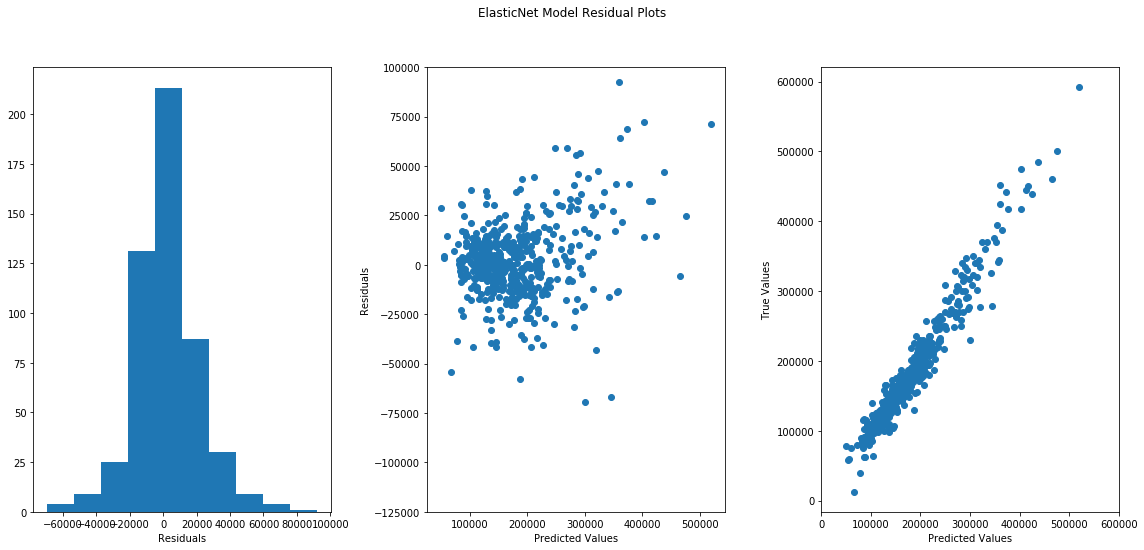

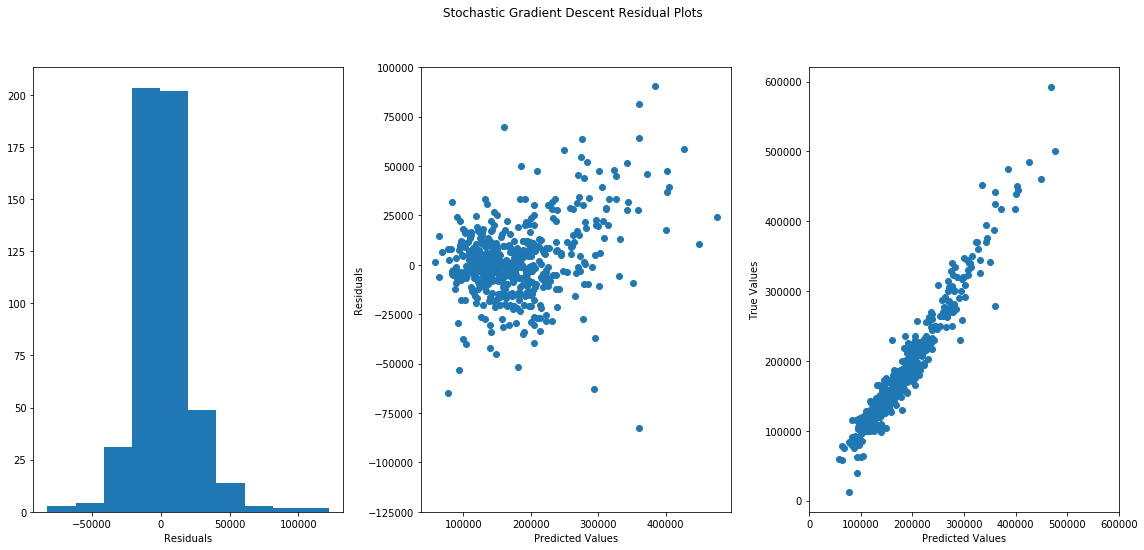

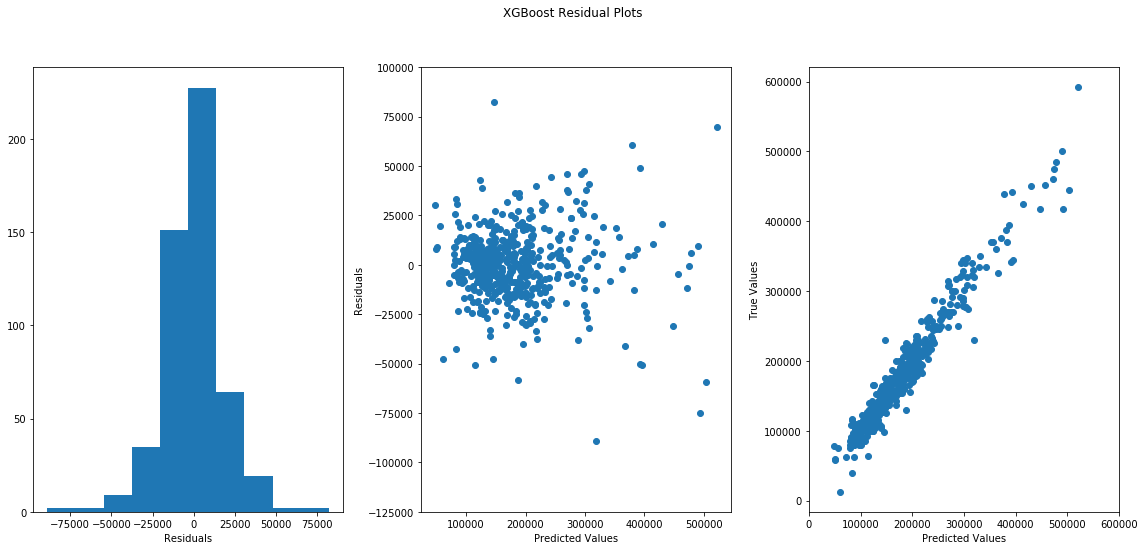

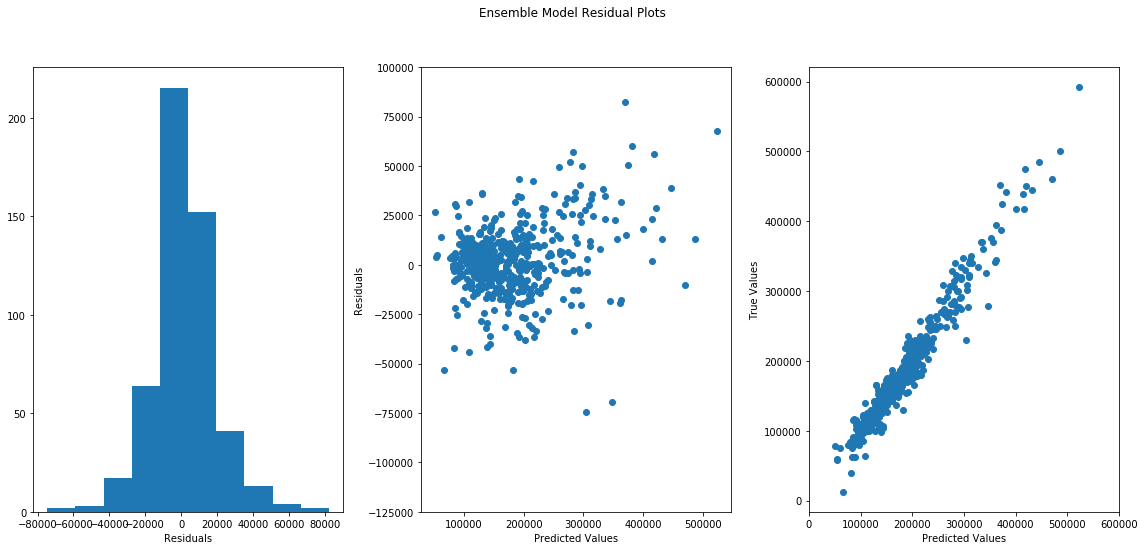

In [128]:
for pred, title in preds_and_titles:
    resid_plots(pred,title);

Examining our residual plots against holdout data, we see solid normality of residuals, tolerable but noteworthy heteroscedasticity, and strong linearity in the relationship between predicted and true values. While our model has some issues with predicting very high values, we're confident in the overall fit.

## Conclusion & Recommendations

Our final model has an MSRE of 17894, which can be taken to mean "The average error in predicted sale price for the model is \\$17,894."

We believe this model is fundamentally sound, as it violates only one LINE assumption (homoscedasticity), and does not show signs of overfitting based on the difference in R2 scores for training and holdout data. Its final test will be against Kaggle, where we are 2nd on the leaderboard at time of writing with an MSRE of 19698.

While the low-level projection of the model (Sale Price plus or minus MSRE) is easily interpretable, it is important to note that we have not selected models whose coefficients can be interpreted straightforwardly, particularly due to transformations of our independent variables. This is still addressable in a production context with some work, but is an evaluation factor depending on the context of application. Since the uniform-weight ensemble model is simply the mean of all 5 input model's predictions, we can distinguish how much weight each individual X-variable in a given prediction, and what that impact had on the overall valuation.

We believe this is a strong proof-of-concept for an on-demand housing valuation model, and should be the basis for Parameter Inc.'s housing valuation product moving forward.

## References

- [Plaintext Data Dictionary](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)
- [Formatted Data Dictionary (Kaggle)](https://www.kaggle.com/c/dsi-us-12-project-2-regression-challenge/data)
- [Reference for management of data cleaning with variable values in training and test set](https://medium.com/@vaibhavshukla182/how-to-solve-mismatch-in-train-and-test-set-after-categorical-encoding-8320ed03552f)
- [Heavily referenced notebook for feature engineering workflow. Attribution given in markdown where code was copied or adapted](https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset)
- [Heavily referenced notebook for feature engineering, XGBoost Hyperparameter benchmarks, and ensemble model implementation](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)
- [Reference for selecting SGDRegressor Hyperparameters](http://dsdeepdive.blogspot.com/2015/08/hyperparameter-optimization-with-python.html)
- [Code used for selecting XGBoost Hyperparameters](https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f)